In [1]:
import pickle
import cv2
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import random
import textwrap
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data_dir = 'C:/Users/admin/Downloads/cifar-10-python/cifar-10-batches-py'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir):
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch = unpickle(f'{data_dir}/data_batch_{i}')
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']

    train_data = np.concatenate(train_data)
    train_labels = np.array(train_labels)

    test_batch = unpickle(f'{data_dir}/test_batch')
    test_data = test_batch[b'data']
    test_labels = np.array(test_batch[b'labels'])

    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return train_data, train_labels, test_data, test_labels

# Load and preprocess the dataset
train_data, train_labels, test_data, test_labels = load_cifar10(data_dir)

train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Create an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_data)

print("Data loaded and preprocessed successfully!")

Data loaded and preprocessed successfully!


In [3]:
# Initialize SIFT
sift = cv2.SIFT_create()

def convert_to_uint8(image):
    if image.dtype == np.float32:
        image = np.clip(image, 0, 1) * 255
        image = image.astype(np.uint8)
    elif image.dtype == np.float64:
        image = np.clip(image, 0, 1) * 255
        image = image.astype(np.uint8)
    elif image.dtype == np.int32 or image.dtype == np.int64:
        image = np.clip(image, 0, 255)
        image = image.astype(np.uint8)
    return image

def extract_sift_features(images):
    descriptors_list = []
    valid_indices = []

    for idx, img in enumerate(images):
        if img is None:
            print(f"Warning: Image at index {idx} is not loaded correctly.")
            continue

        img = convert_to_uint8(img)

        try:
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        except cv2.error as e:
            print(f"Warning: Error converting image at index {idx} to grayscale: {e}")
            continue

        if img_gray.dtype != np.uint8:
            print(f"Warning: Image at index {idx} has incorrect depth: {img_gray.dtype}")
            continue

        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Warning: No descriptors found for image at index {idx}.")

    return descriptors_list, valid_indices

# Extract SIFT features from train and test images
train_descriptors_list, train_valid_indices = extract_sift_features(train_data)
test_descriptors_list, test_valid_indices = extract_sift_features(test_data)

# Flatten the list of descriptors for k-means clustering
all_descriptors = np.vstack(train_descriptors_list + test_descriptors_list)

# Perform k-means clustering to create the visual words
num_clusters = 50  # Experiment with different number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(all_descriptors)

# Save the visual word vocabulary
vocabulary = kmeans.cluster_centers_

# Function to create BoW histograms
def create_bow_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        words = kmeans.predict(descriptors)
        histogram, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1), density=True)
        histograms.append(histogram)
    return np.array(histograms)

# Create BoW histograms for train and test data
train_bow_histograms = create_bow_histograms(train_descriptors_list, kmeans)
test_bow_histograms = create_bow_histograms(test_descriptors_list, kmeans)

# Normalize features
scaler = StandardScaler()
train_bow_histograms = scaler.fit_transform(train_bow_histograms)
test_bow_histograms = scaler.transform(test_bow_histograms)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
# Train an SVM classifier
svm = SVC(kernel='linear')
svm.fit(train_bow_histograms, train_labels[train_valid_indices])

# Predict and evaluate on test data
test_predictions = svm.predict(test_bow_histograms)
print("BoW SVM Classification Report:")
print(classification_report(test_labels[test_valid_indices], test_predictions))

print("Confusion Matrix:")
print(confusion_matrix(test_labels[test_valid_indices], test_predictions))

BoW SVM Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.37      0.34       993
           1       0.27      0.29      0.28      1000
           2       0.19      0.11      0.14       998
           3       0.19      0.15      0.16       999
           4       0.16      0.11      0.13       999
           5       0.22      0.29      0.25      1000
           6       0.21      0.19      0.20      1000
           7       0.24      0.23      0.23      1000
           8       0.27      0.34      0.30       997
           9       0.25      0.29      0.27      1000

    accuracy                           0.24      9986
   macro avg       0.23      0.24      0.23      9986
weighted avg       0.23      0.24      0.23      9986

Confusion Matrix:
[[364  75  82  38  37  42  47  83 156  69]
 [ 68 292  32  35  49 103  84  41 133 163]
 [188  71 112  63  70 120 101  99 101  73]
 [ 48  77  56 146  73 199 105  94  82 119]
 [ 75  85  92  87 11

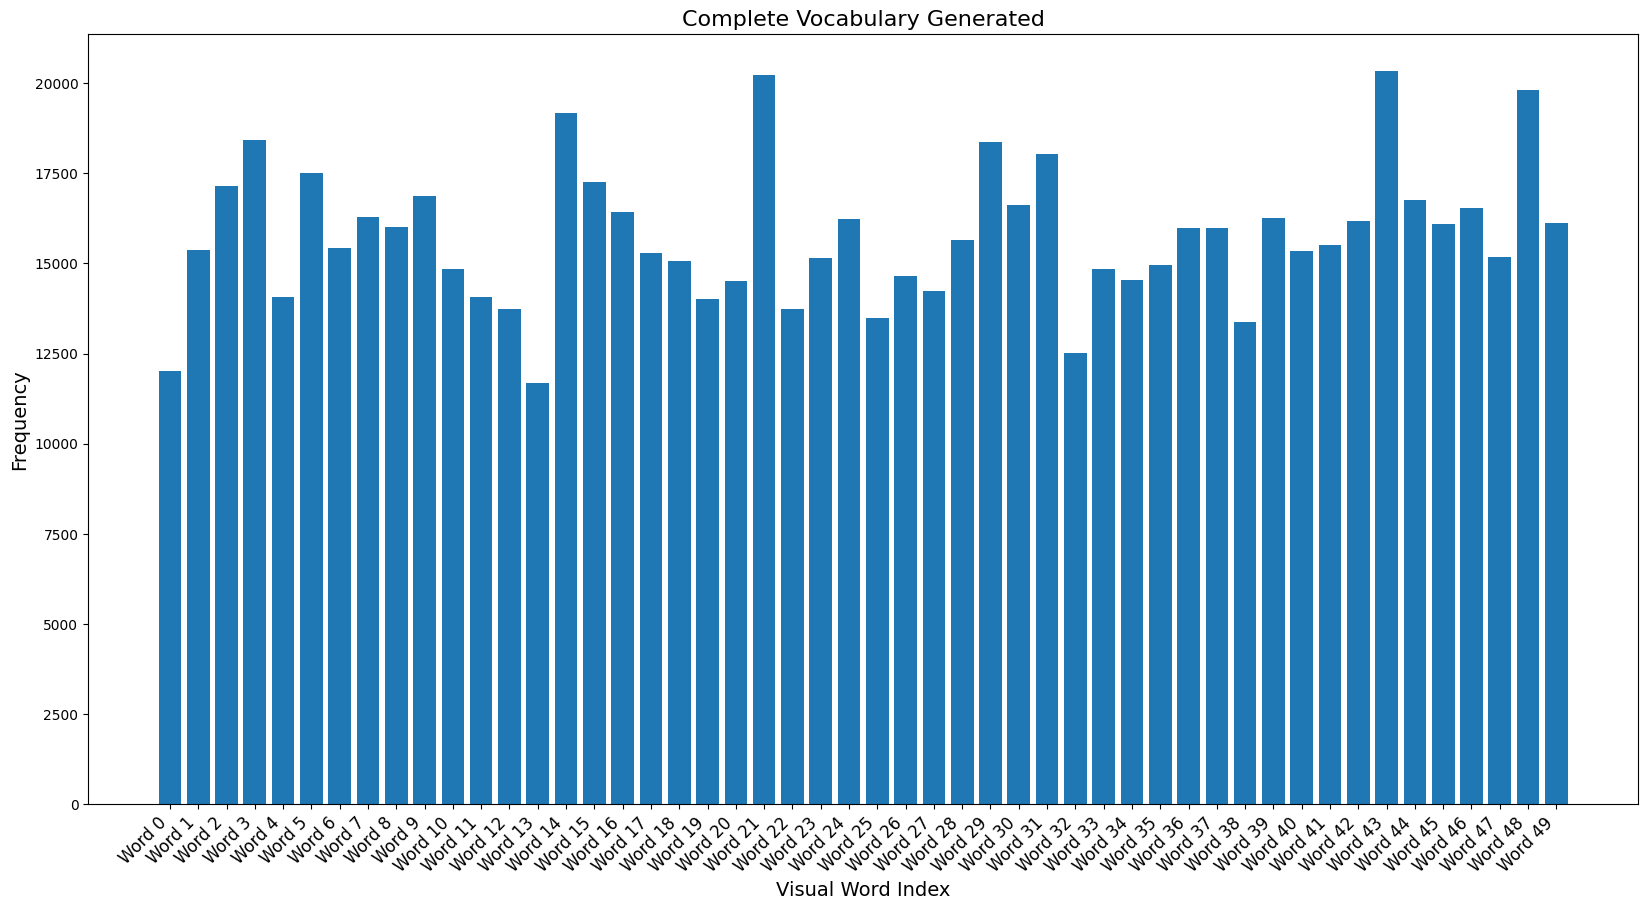

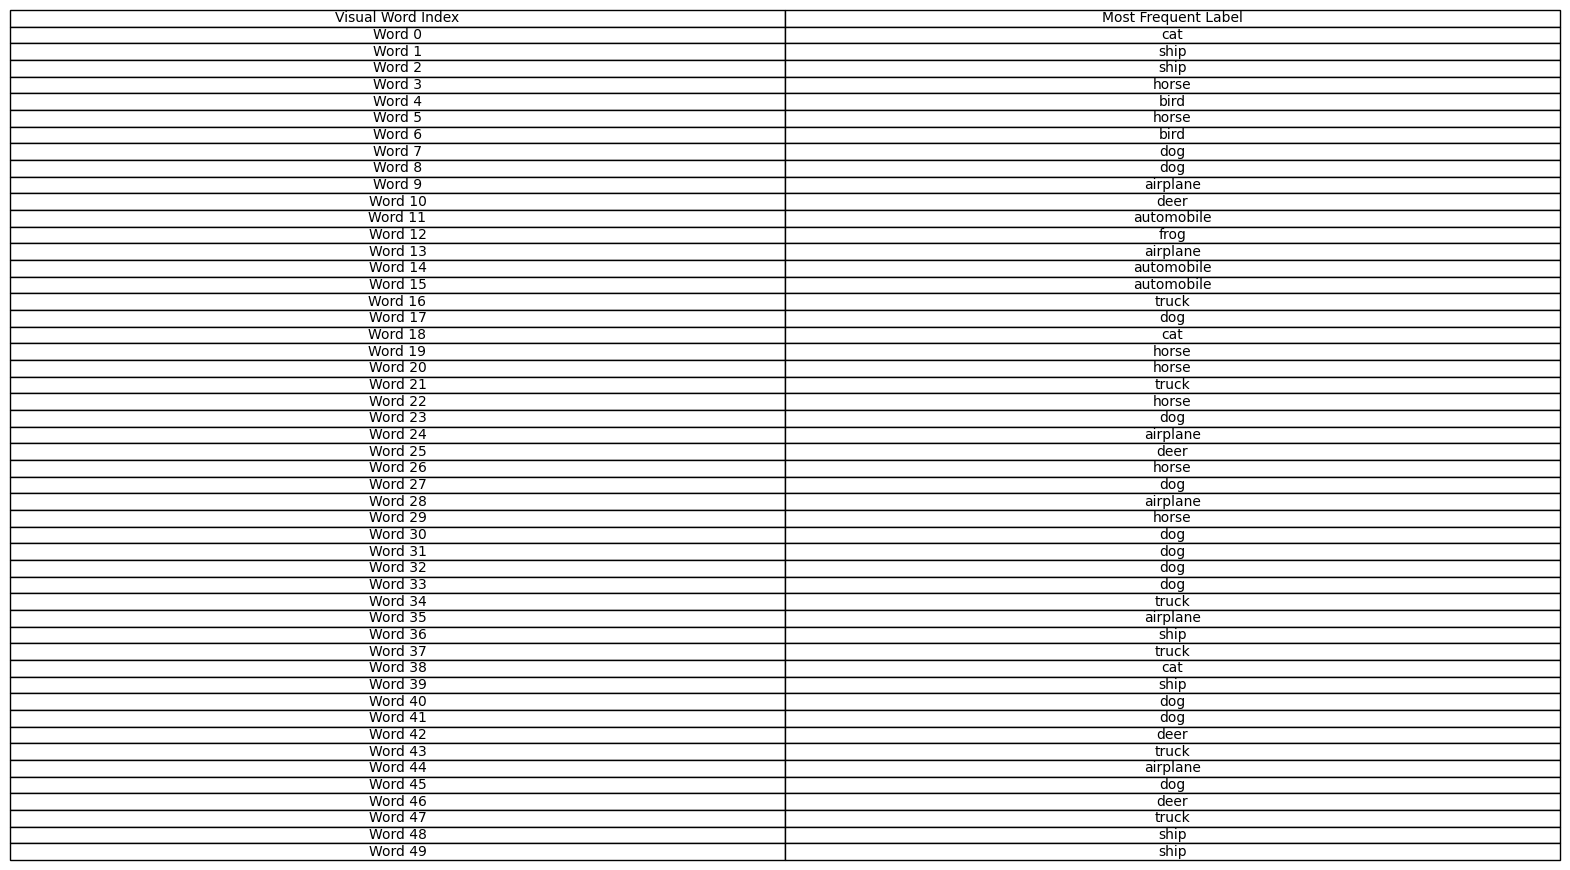

In [5]:
# CIFAR-10 labels
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Count the most frequent class labels for each visual word
visual_word_labels = {i: [] for i in range(num_clusters)}

for i, descriptors in enumerate(train_descriptors_list):
    words = kmeans.predict(descriptors)
    most_frequent_word = np.argmax(np.bincount(words))
    visual_word_labels[most_frequent_word].append(train_labels[train_valid_indices[i]])

# Find the most frequent class label for each visual word
visual_word_class_labels = {}
for word, labels in visual_word_labels.items():
    if labels:
        most_common_label = Counter(labels).most_common(1)[0][0]
        visual_word_class_labels[word] = cifar10_labels[most_common_label]
    else:
        visual_word_class_labels[word] = 'Unknown'

# Visualize the frequency of visual words with their labels
word_counts = np.bincount(kmeans.labels_)
visual_word_labels = [f'Word {i}' for i in range(num_clusters)]

# Adjust figure size for the plot
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.bar(range(num_clusters), word_counts)
ax.set_xlabel('Visual Word Index', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Complete Vocabulary Generated', fontsize=16)

# Keep x-axis labels simple
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(visual_word_labels, rotation=45, ha='right', fontsize=12)

# Prepare the index/legend in a separate table
index_table = [[f'Word {i}', visual_word_class_labels[i]] for i in range(num_clusters)]

# Create a new figure for the index table
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=index_table, colLabels=['Visual Word Index', 'Most Frequent Label'], cellLoc='center', loc='center')

# Display both plots
plt.show()